# Santander Customer Transaction Prediction

At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

https://www.kaggle.com/c/santander-customer-transaction-prediction

## 1. Initial Imports

In [1]:
import pandas as pd
import numpy as np
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

---

## 2. Checking out Data

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
print(f'We have {train.shape[0]} observations and {train.shape[1]-2} features in training set.')
print(f'We have {test.shape[0]} observations and {test.shape[1]-1} features in test set.')

We have 200000 observations and 200 features in training set.
We have 200000 observations and 200 features in test set.


In [5]:
for x in [test, train]:
    isna = x.isna().sum()
    print(isna[isna > 0])

Series([], dtype: int64)
Series([], dtype: int64)


There are none NaN values in neither train or test data.

In [6]:
train.dtypes.value_counts()

float64    200
object       1
int64        1
dtype: int64

All features are float64 types.

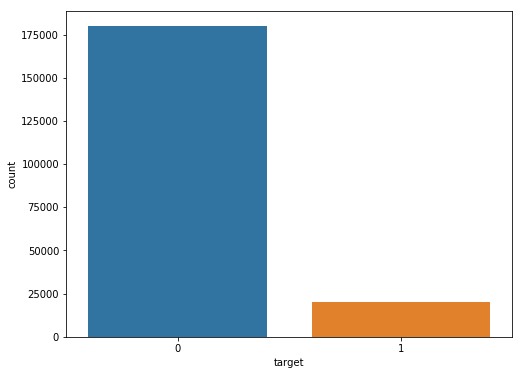

y = 0: 89.95% of total.
y = 1: 10.05% of total.


In [7]:
plt.figure(figsize=(8,6))
sns.countplot(train.target)
plt.show()
print('y = 0: {:.2%} of total.'.format(train.target.value_counts()[0]/train.target.count()))
print('y = 1: {:.2%} of total.'.format(train.target.value_counts()[1]/train.target.count()))

We can see that the target is unbalanced, to deal with that we can try to use resampling. Since we have several observations, we can try to undersample the training set to match the observations, but I won't do this now.

In [8]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train.loc[:,'target']

---

## 3. LightGBM


In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(train.shape[0])
predictions = np.zeros(train.shape[0])
feature_importance_df = pd.DataFrame()

In [23]:
param = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5,
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': True,
    }

In [24]:
start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train.values, target.values)):
    print("Fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
end = time.time()

Fold n°0
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904591	valid_1's auc: 0.886209
[2000]	training's auc: 0.920619	valid_1's auc: 0.894551
[3000]	training's auc: 0.930536	valid_1's auc: 0.897936
[4000]	training's auc: 0.937944	valid_1's auc: 0.898969
[5000]	training's auc: 0.944588	valid_1's auc: 0.899581
Early stopping, best iteration is:
[5005]	training's auc: 0.944618	valid_1's auc: 0.899587
Fold n°1
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.905209	valid_1's auc: 0.882029
[2000]	training's auc: 0.920934	valid_1's auc: 0.890459
[3000]	training's auc: 0.930768	valid_1's auc: 0.894718
[4000]	training's auc: 0.938183	valid_1's auc: 0.896357
Early stopping, best iteration is:
[4818]	training's auc: 0.943587	valid_1's auc: 0.897
Fold n°2
Training until validation scores don't improve for 100 rounds.
[1000]	training's auc: 0.904225	valid_1's auc: 0.886743
[2000]	training's auc: 0.920401	valid_1's auc

In [25]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

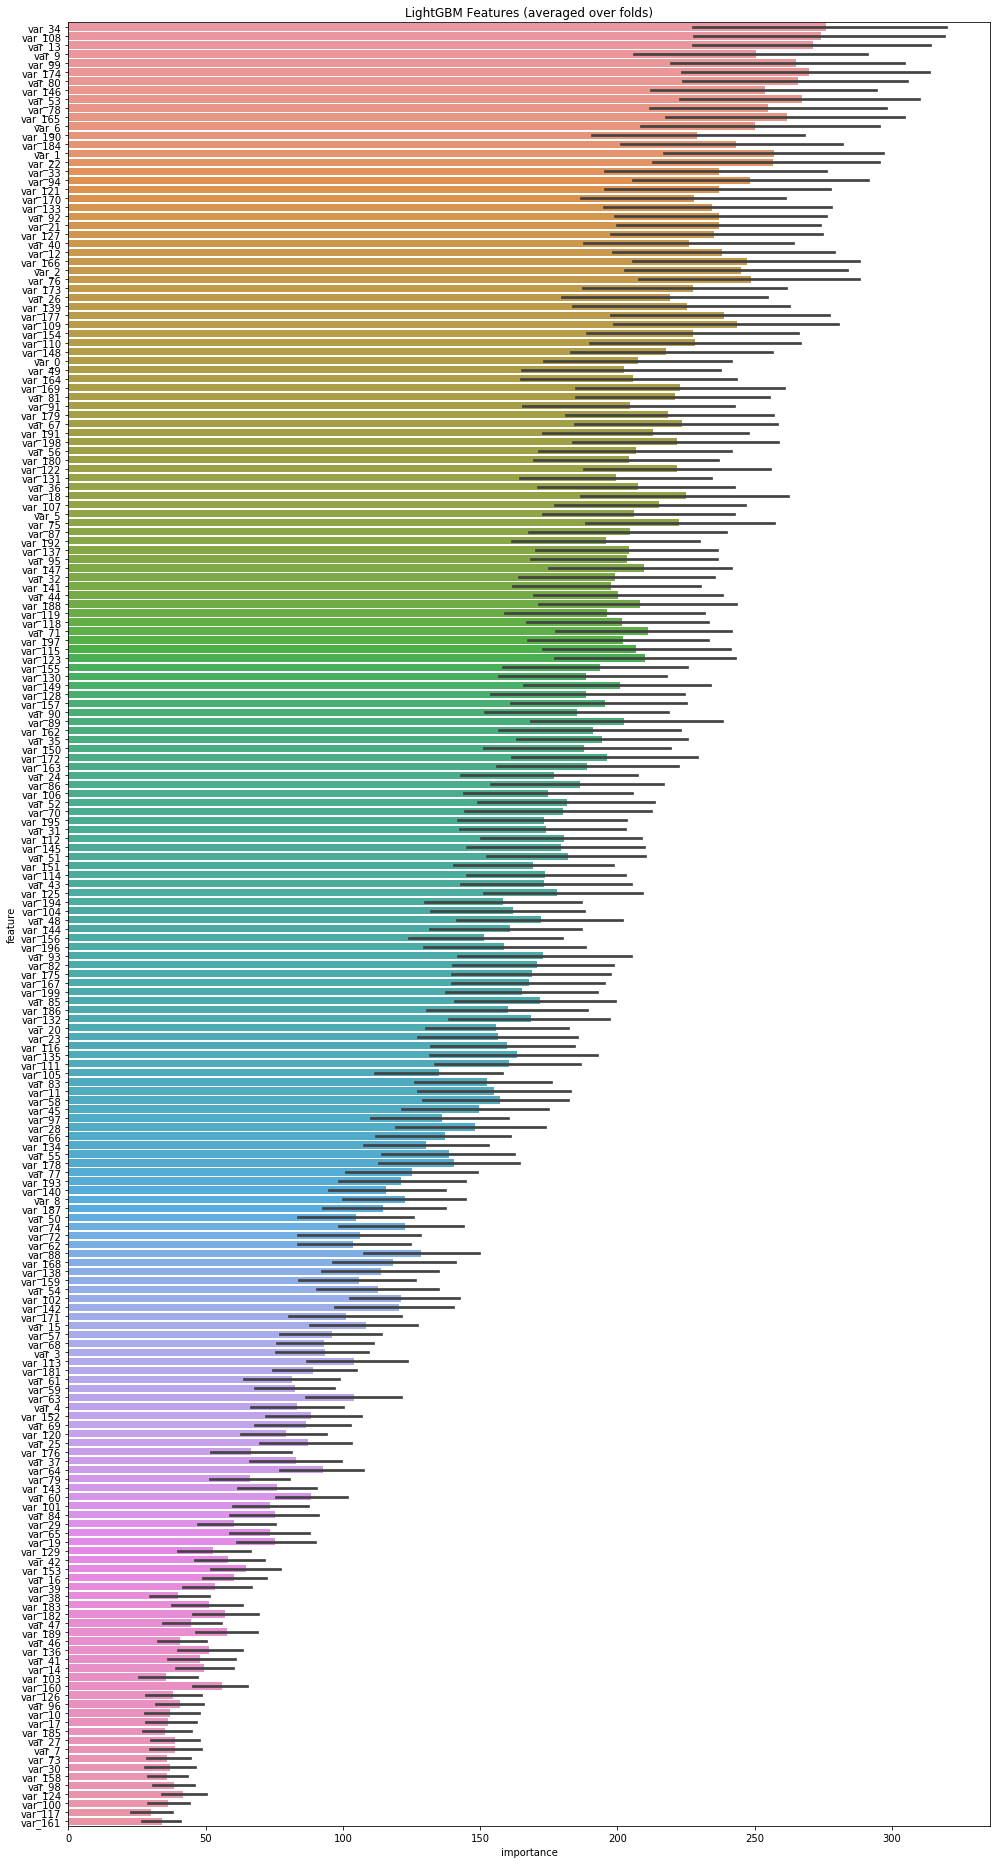

In [26]:
plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [117]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("lgb_submission.csv", index=False)